In [1]:
%load_ext autoreload
%autoreload 2

# EDA
We will go through EDA with the help of [this notebook](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook) from Kaggle, by [Gunes Evitan](https://www.kaggle.com/gunesevitan)

In [2]:
from sklearn.datasets import fetch_20newsgroups
all_xs, all_y = fetch_20newsgroups(subset="all", remove=('headers', 'footers', 'quotes'),
                    shuffle=True, return_X_y=True)

In [19]:
len(all_xs)

18846

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from pathlib import Path
from fastai.text.all import *

plt.rcParams["figure.dpi"] = 100

In [4]:
import sys
# NOTE: you NEED to change PATH yourself manually, for now. 
path = Path("/home/fastai2/notebooks/DataGlacier")  
sys.path.append(str(path/"NLP_GroupProject_DG/python_files"))

In [5]:
from nlputils import split_data, clean_data, stoi

In [6]:
all_xs = [clean_data(text) for text in all_xs]  # basic cleaning. 
# further cleaning on removing those unneeded data can be done here
# such as those with german, those illegible, etc. 
df = pd.DataFrame([all_xs, all_y]).T
df.columns = ["text", "category"]
df.head(2)

,text,category
0,"I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to nonPIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey a...",10
1,My brother is in the market for a highperformance video card that supports VESA local bus with 12MB RAM. Does anyone have suggestions/ideas on: Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other highperformance VLB card Please post or email. Thank you! Matt,3


## Cleaning out for non-useful data
These are the ones that are one-off. E.g. they contains pure coordinates, pure programming code, pure german language, etc. Previously we did this and saved the data, but only if we choose those data with sentence higher than threshold then we can use that here. Since we're using the full data here, we shall do the cleaning again. We shall build the `DataLoaders` from original code, to imitate the originals as close as possible. 

In [13]:
sl = 72  # seq_len

try: tok = load_pickle("tok.pkl")
except Exception:
    dls = DataBlock(
        blocks=(TextBlock.from_df("text", seq_len=sl, tok=SpacyTokenizer("en")),
                CategoryBlock),
        get_x=ColReader("text"), get_y=ColReader("category"),
        splitter=RandomSplitter(0.1)
    ).dataloaders(df, bs=32, num_workers=os.cpu_count(), seq_len=sl)

    save_pickle("tok.pkl", dls.tok)
    tok = dls.tok

In [14]:
df_tok, unique_words = tokenize_df(df, "text", tok=tok)
df_tok[["category", "text", "text_length"]].head(2)

/anaconda/envs/fastai/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


,category,text,text_length
0,10,"[xxbos, i, am, sure, some, bashers, of, xxmaj, pens, fans, are, pretty, confused, about, the, lack, of, any, kind, of, posts, about, the, recent, xxmaj, pens, massacre, of, the, xxmaj, devils, ., xxmaj, actually, ,, i, am, bit, puzzled, too, and, a, bit, relieved, ., xxmaj, however, ,, i, am, going, to, put, an, end, to, nonpittsburghers, ', relief, with, a, bit, of, praise, for, the, xxmaj, pens, ., xxmaj, man, ,, they, are, killing, those, xxmaj, devils, worse, than, i, thought, ., xxmaj, jagr, just, showed, you, why, he, is, much, better, than, his, regular, season, stats, ., xxmaj, ...]",169
1,3,"[xxbos, xxmaj, my, brother, is, in, the, market, for, a, highperformance, video, card, that, supports, xxup, vesa, local, bus, with, 12, mb, xxup, ram, ., xxmaj, does, anyone, have, suggestions, /, ideas, on, :, xxmaj, diamond, xxmaj, stealth, xxmaj, pro, xxmaj, local, xxmaj, bus, xxmaj, orchid, xxmaj, farenheit, 1280, xxup, ati, xxmaj, graphics, xxmaj, ultra, xxmaj, pro, xxmaj, any, other, highperformance, xxup, vlb, card, xxmaj, please, post, or, email, ., xxmaj, thank, you, !, xxmaj, matt]",76


In [15]:
try: choice = np.load("choice.npy")
except Exception:
    choice = np.zeros((len(df_tok), )).astype(np.float32)
    loop_over = df_tok["text"].to_numpy()

    vocab = dls.vocab[0]
    for k, data in enumerate(tqdm(loop_over)):
        x = stoi(vocab, data)

        # Total number of xxunk / total number of words. 
        choice[k] = (x == 0).sum() / len(x)

    del loop_over, vocab, x, data
    gc.collect()
    np.save("choice", choice)

In [28]:
del_thres = choice < 0.25
df = df[del_thres].reset_index(level=0, drop=True)
df_tok = df_tok[del_thres].reset_index(level=0, drop=True)

In [29]:
len(df)

18794

Parallel compute using joblib threads takes: 3 min 07 sec.  
Singular compute using for-loop takes: 2 min 38.8 sec. 

### Let's continue with data analysis

In [45]:
df[df.category == 10].head(2)

,text,category
0,"I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to nonPIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey a...",10
7,"[stuff deleted] Ok, here's the solution to your problem. Move to Canada. Yesterday I was able to watch FOUR games...the NJPITT at 1:00 on ABC, LACAL at 3:00 (CBC), BUFFBOS at 7:00 (TSN and FOX), and MONQUE at 7:30 (CBC). I think that if each series goes its max I could be watching hockey playoffs for 40some odd consecutive nights (I haven't counted so that's a pure guess). I have two tv's in my house, and I set them up sidebyside to watch MONQUE and keep an eye on BOSBUFF at the same time. I did the same for the two afternoon games. Btw, those ABC commentaters were great! I was q...",10


Line numbers count and "potentially" word count.

In [46]:
%%time
df["word_count"] = df["text"].apply(lambda x: len(str(x).split()))
df["line_count"] = df["text"].apply(lambda x: len(split_data(str(x))))

CPU times: user 346 ms, sys: 0 ns, total: 346 ms
Wall time: 345 ms


In [47]:
df.head()

,text,category,word_count,line_count
0,"I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to nonPIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey a...",10,137,1
1,My brother is in the market for a highperformance video card that supports VESA local bus with 12MB RAM. Does anyone have suggestions/ideas on: Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other highperformance VLB card Please post or email. Thank you! Matt,3,48,1
2,"Finally you said what you dream about. Mediterranean???? That was new.... The area will be ""greater"" after some years, like your ""holocaust"" numbers...... Is't July in USA now????? Here in Sweden it's April and still cold. Or have you changed your calendar??? NOTHING OF THE MENTIONED IS TRUE, BUT LET SAY IT's TRUE. SHALL THE AZERI WOMEN AND CHILDREN GOING TO PAY THE PRICE WITH BEING RAPED, KILLED AND TORTURED BY THE ARMENIANS?????????? HAVE YOU HEARDED SOMETHING CALLED: ""GENEVA CONVENTION""??????? YOU FACIST!!!!! Ohhh i forgot, this is how Armenians fig...",17,234,1
3,Think! It's the SCSI card doing the DMA transfers NOT the disks... The SCSI card can do DMA transfers containing data from any of the SCSI devices it is attached when it wants to. An important feature of SCSI is the ability to detach a device. This frees the SCSI bus for other devices. This is typically used in a multitasking OS to start transfers on several devices. While each device is seeking the data the bus is free for other commands and data transfers. When the devices are ready to transfer the data they can aquire the bus and send the data. On an IDE bus when you start a transf...,3,144,1
4,"1) I have an old Jasmine drive which I cannot use with my new system. My understanding is that I have to upsate the driver with a more modern one in order to gain compatability with system 7.0.1. does anyone know of an inexpensive program to do this? ( I have seen formatters for $20 buit have no idea if they will work) 2) I have another ancient device, this one a tape drive for which the back utility freezes the system if I try to use it. THe drive is a jasmine direct tape (bought used for $150 w/ 6 tapes, techmar mechanism). Essentially I have the same question as above, any...",4,125,1


<AxesSubplot:xlabel='word_count', ylabel='Count'>

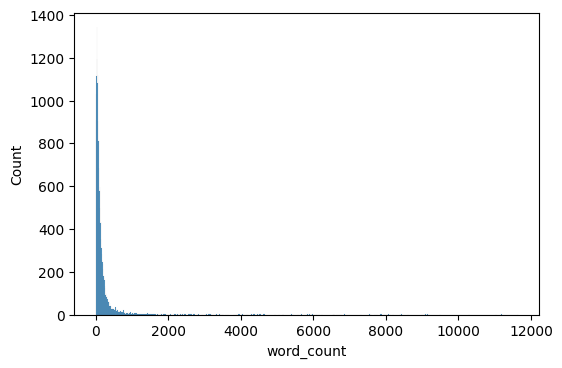

In [48]:
sns.histplot(df["word_count"])

Looks like word count we have a very long tail (and very means very very very...). Most of the data are short, and perhaps they're more representative? 

For example, previously we take a threshold which says: *for data less than this number of lines, we discard it*. Perhaps we should have been doing the other way round: *for data more than certain number of lines, we discard it* is the better way! 

We have updated `threshold_subset` to include an arg called `geq` to do this. 

<AxesSubplot:xlabel='word_count', ylabel='Count'>

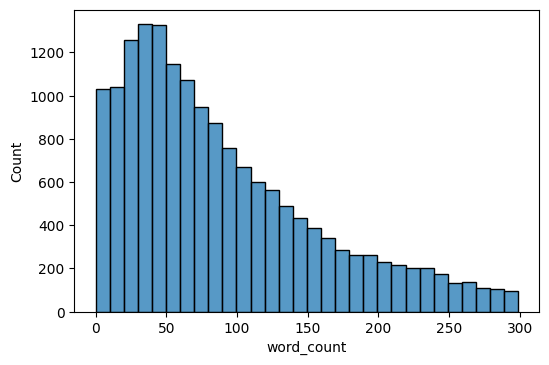

In [49]:
sns.histplot(df[df["word_count"] < 300]["word_count"], bins=30)

<AxesSubplot:xlabel='line_count', ylabel='Count'>

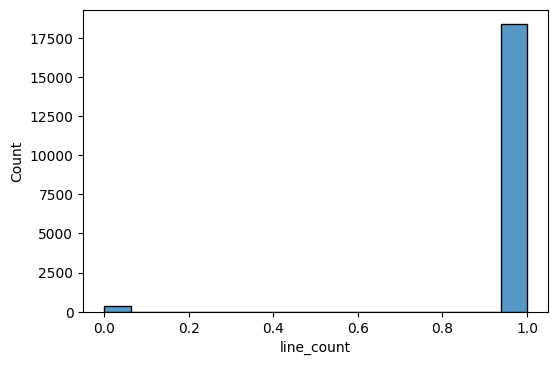

In [50]:
sns.histplot(df["line_count"])

<AxesSubplot:xlabel='line_count', ylabel='Count'>

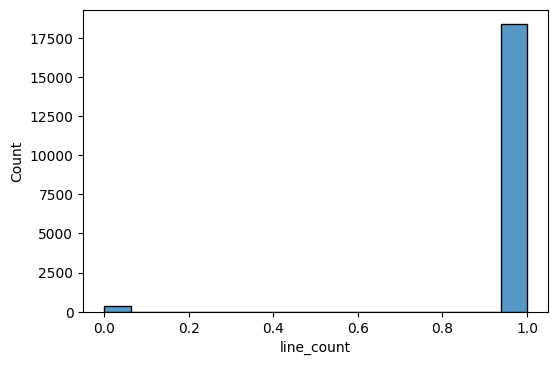

In [51]:
sns.histplot(df[df.line_count < 30].line_count)

### Food for thoughts:
- This is NLP, not Tabular data. Do you think it's better to remove data that are outliers? 
- Do you think really most of the information are aggregated in the long articles? Or most in short articles? What are their differences? 

These are not something that you can visualize using graphs. Honestly to deal with them, EDA isn't the best way. There are 2 ways to do: 
- EDA: **manually** read the paragraphs yourself and determine whether they're useful or not, either by yourself, with a group, via debate, or any other means to make decisions. 
- ML: Train a model with and without certain group, and see how does the loss do. And make decisions based on loss, accuracy, or any other metrics we define to meet our needs. (Black box decision making).

The latter being a faster decision maker, and more useful if you would like to optimize for better ML results making rather than understanding. 

Let us continue next and look at stop word count, and we also do unique word count. 

In [52]:
from sklearn.feature_extraction import _stop_words
STOPWORDS = _stop_words.ENGLISH_STOP_WORDS

In [53]:
df["stop_word_count"] = df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

In [54]:
df.head(2)

,text,category,word_count,line_count,stop_word_count
0,"I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils. Actually, I am bit puzzled too and a bit relieved. However, I am going to put an end to nonPIttsburghers' relief with a bit of praise for the Pens. Man, they are killing those Devils worse than I thought. Jagr just showed you why he is much better than his regular season stats. He is also a lot fo fun to watch in the playoffs. Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey a...",10,137,1,72
1,My brother is in the market for a highperformance video card that supports VESA local bus with 12MB RAM. Does anyone have suggestions/ideas on: Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other highperformance VLB card Please post or email. Thank you! Matt,3,48,1,14


<AxesSubplot:xlabel='stop_word_count', ylabel='Count'>

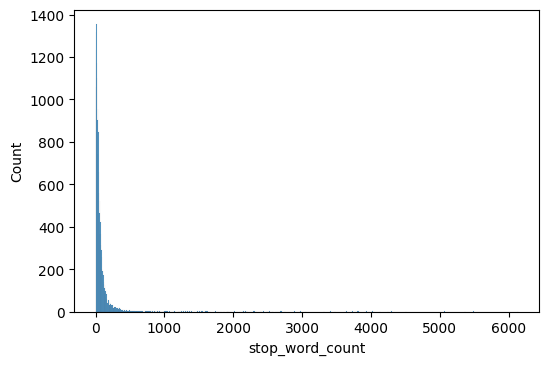

In [55]:
sns.histplot(df["stop_word_count"])

<AxesSubplot:xlabel='stop_word_count', ylabel='Count'>

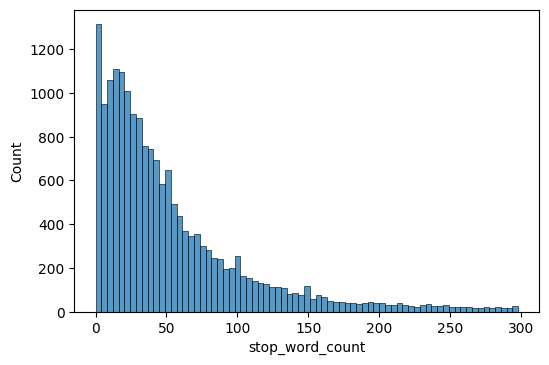

In [56]:
sns.histplot(df[df.stop_word_count < 300].stop_word_count)

### Let's look at the unique words a bit.

In [57]:
unique_words.most_common(50)

[('xxmaj', 397733),
 (',', 174208),
 ('the', 173279),
 ('.', 171283),
 ('xxup', 132260),
 ('to', 86524),
 ('of', 76997),
 ('a', 70479),
 ('and', 69810),
 ('i', 56691),
 ('in', 50450),
 ('is', 49919),
 ('that', 45958),
 (')', 44595),
 ('"', 42964),
 ('(', 40475),
 ('it', 38466),
 ('/', 37311),
 (':', 34670),
 ('for', 32227),
 ('you', 30444),
 ('?', 23926),
 ('this', 23479),
 ('on', 23317),
 ('be', 21961),
 ('have', 21891),
 ('not', 21417),
 ('are', 21349),
 ('with', 20868),
 ("'s", 19371),
 ('#', 18934),
 ('xxbos', 18846),
 ('as', 18674),
 ('or', 17262),
 ("n't", 17083),
 ("'", 17036),
 ('\\', 16463),
 ('was', 16368),
 ('do', 15831),
 ('if', 15692),
 ('but', 15499),
 ('they', 15255),
 ('from', 13533),
 ('by', 13232),
 ('=', 13017),
 ('at', 12601),
 ('can', 12197),
 ('an', 11689),
 ('3', 11213),
 ('there', 11089)]

This isn't too explaining actually. But we can see some words appears quite often, but they didn't really distinguish between different categories, seriously speaking. Capital letters `xxmaj` seems to flood the articles, even more than punctuations like full stop. 

Also note that this counter is expired. We count it when we still have the dirty data, but now we have one pass through to clean those with lots of xxunk (threshold value 0.25). 

However, we may get some insights if we get the max number of counts after we split the data based on their categories. 

In [60]:
tok_text = df_tok["text"].to_numpy()
tok_text.shape

(18794,)

In [61]:
sorted(df_tok.category.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [62]:
import gc
from tqdm.notebook import tqdm
from collections import Counter
import joblib

In [63]:
def cat_counter(df_tok):
    """
    Counter of most frequent words based on category. 
    Sorted by category already. 
    """
    cache = []  # {}

    # def inner_(cat): 
    #     counter = Counter()
    #     temp_np = df_tok[df_tok.category == cat].text.to_numpy()
    #     for sentence in temp_np: counter += Counter(sentence)
    #     cache[cat] = counter
    #     del counter, temp_np, sentence

    # _ = joblib.Parallel(n_jobs=os.cpu_count(), prefer="threads")(
    #     joblib.delayed(inner_)(cat)
    #     for cat in tqdm(range(20))
    # )

    for cat in tqdm(range(20)):  # sorted
        counter = Counter()
        temp_np = df_tok[df_tok.category == cat].text.to_numpy()
        for sentence in temp_np: counter += Counter(sentence)
        # cache[cat] = counter
        cache.append(counter)
        del counter, temp_np, sentence
    gc.collect()
    return cache

In [64]:
counters = cat_counter(df_tok)

  0%|          | 0/20 [00:00<?, ?it/s]

In [65]:
import re
from tabulate import tabulate
from IPython.display import display, HTML

In [78]:
def print_top_k_common(counters, k=10, return_val=False, to_be_deleted=None):
    """
    Display top k words with html table. 

    :return_val: (bool) Whether to return result or not. Default: False. 
    :to_be_deleted: (list) What to exclude from count. Default: None
        (so only xxmaj excluded. )
    """
    r = re.compile(r'\n+')
    to_del = ["xxmaj"]
    if to_be_deleted is None: to_be_deleted = to_del
    else: to_be_deleted += to_del
    # +50 to replace the ones in the line marked **. Have caveats. 
    # only works as long as you don't exhaust the below. 
    top_k = [counter.most_common(k+len(to_be_deleted)+50) for counter in counters]
    top_k = [np.array([list(word) for word in counter])
                for counter in top_k]
    for i in range(len(top_k)): 
        a = top_k[i][:, 0]
        to_be_deleted += list(set(filter(r.match, a)))  # **
        for d in to_be_deleted: a = np.delete(a, np.where(a == d))
        if len(a) > k: a = a[:k]
        top_k[i] = [i] + list(a)
        

    display(HTML(tabulate(top_k, 
                    headers=["category", *range(k)],
                    tablefmt="html")))
    if return_val: return top_k

In [81]:
m = print_top_k_common(counters, 15, True, 
    to_be_deleted=""". , " ' / # \\ = : - ( ) ; * ▁ to and xxup i a of the
                    you that in xxbos is it for not ? ! … `
                    this with have but if n't they was are as or
                    be at on were he 's we""".split())

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,do,what,an,by,one,can,god,there,so,your,all,from,no,would,people
1,image,from,can,xxrep,an,graphics,jpeg,do,by,will,],3,there,file,[
2,max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax,_,t,windows,],g9v,$,p,m,%,w,&,do,3,xxrep
3,my,drive,can,do,an,any,3,xxrep,from,there,2,card,will,one,would
4,can,my,do,mac,from,an,xxrep,apple,what,3,one,would,any,has,there
5,x,3,xxrep,can,an,from,do,by,window,file,use,your,$,will,my
6,$,1,2,3,all,xxrep,new,me,sale,4,will,email,please,offer,one
7,car,my,do,xxrep,about,there,3,would,can,from,an,your,so,any,out
8,my,do,bike,your,me,about,one,from,there,so,would,all,xxrep,just,out
9,3,do,his,would,xxrep,1,year,0,has,game,so,out,there,all,up


You notice something like `n't` because fastai knows that a word such as `don't` should be split up (just like stemming and lemmatization) into `do` and `n't`. The contractions aren't split into full by fastai's method. 

In [82]:
m[10]

[10,
 '1',
 '0',
 '2',
 '3',
 '4',
 '5',
 'game',
 'team',
 '6',
 'will',
 'xxrep',
 '7',
 'from',
 'do',
 'his']

And category 10 seems to have quite a few numbers inside. One wonders what category 10 represents that it uses quite some numbers. OR it may be due to that kind of data that's dirty (there're data we see before during data cleaning that contains lots of coordinates), which may result in this. 

Looks like we need to make further cleaning. 

In [84]:
counters[2].most_common(11)

[('xxup', 22253),
 ('xxmaj', 11149),
 ('/', 9165),
 ('\\', 7332),
 (',', 7121),
 ('.', 6279),
 ("'", 6005),
 ('=', 5780),
 ('#', 5438),
 ('the', 4897),
 ("max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax", 3201)]

Up till now we have delete quite a lot of words and we still can't find a unique set of words to distinguish between the categories. So either we continue to delete words, or we just stop here and see through it (let it be) as a failed experiment. 

However one insight one wants to talk about is this category 2 have a count for this: `max>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax>'ax`, and if one is sure about it, it might be True for the problematic set of data that keeps repeating this. One thinks one deleted the file during training (data cleaning) but not here for EDA. 

Well, that's for unigram. One just noticed that we can do this from the [reference notebook](https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert/notebook)

To deal with bigram and trigrams, we might have to strip away punctuations in the data? Let's also do for unigram with this different method and see how it works. This time, without those cleaning (deleting unnecessary things)

In [86]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

In [ ]:
from collections import defaultdict

In [119]:
def ngram_counter(df, n_gram):
    """
    counter of ngram words based on `generate_ngrams`. 

    :df: (pandas.DataFrame) Original dataframe. NOT tokenized by fastai. 
    :n_gram: What types of n-gram wanted? 

    :return: n_grams for each category
    """
    cache = []

    for cat in tqdm(range(20)):  # sorted
        counter = defaultdict(int)
        temp_np = df[df.category == cat].text.to_numpy()
        for text in temp_np:
            for word in generate_ngrams(text, n_gram=n_gram): 
                counter[word] += 1
        cache.append(Counter(counter))
        del counter, temp_np, text
    gc.collect()
    return cache

In [120]:
unigrams = ngram_counter(df, 1)

  0%|          | 0/20 [00:00<?, ?it/s]

In [121]:
unigrams[0].most_common(10)

[(':', 653),
 ("don't", 417),
 ('people', 411),
 ('god', 354),
 ('just', 342),
 ('think', 336),
 ('does', 322),
 ('#', 318),
 ('believe', 255),
 ('like', 245)]

Ok let's do this for separating categories, just like before. 

In [122]:
def n_gram_by_category(n_grams, k=10, return_val=False):
    """
    :n_grams: (list) containing list of Counters for each category. 
    :k: (int) Top k n-grams displayed. Defaults: 10. 
    :return_val: (bool) Whether to return result or not. Default: False. 

    :caveat: Doesn't display frequency. 
    """
    # +50 to replace the ones in the line marked **. Have caveats. 
    # only works as long as you don't exhaust the below. 
    top_k = [counter.most_common(k) for counter in n_grams]
    top_k = [np.array([list(word) for word in counter])
                for counter in top_k]
    for i in range(len(top_k)): 
        a = top_k[i][:, 0]
        top_k[i] = [i] + list(a)
        

    display(HTML(tabulate(top_k, 
                    headers=["category", *range(k)],
                    tablefmt="html")))
    if return_val: return top_k

In [137]:
n_gram_by_category(unigrams, 15)

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,:,don't,people,god,just,think,does,#,believe,like,say,it's,know,make,i'm
1,image,jpeg,:,file,graphics,use,available,=,data,like,images,software,program,+,does
2,max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax',windows,file,use,dos,:,like,just,using,don't,know,does,files,run,it's
3,:,drive,scsi,use,card,does,just,know,disk,like,hard,ide,i'm,controller,drives
4,mac,apple,does,use,just,know,like,i'm,drive,don't,problem,new,|,need,disk
5,x,/,=,use,window,file,server,using,program,set,available,does,like,{,:
6,1,$,$1,new,2,$2,email,.,&,good,like,asking,shipping,dos,3
7,car,just,like,don't,new,know,:,cars,think,good,it's,/,i'm,engine,|
8,:,bike,just,like,don't,it's,i'm,know,dod,good,think,ride,make,i've,new
9,don't,1,think,just,like,game,0,good,team,2,year,hit,3,it's,better


And we repeat for bigrams and trigrams. 

In [139]:
bigrams = ngram_counter(df, 2)
n_gram_by_category(bigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,: |,# #,don't think,don't know,: :,. .,don't believe,i'm sure,god does,"cheers, kent",/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\ bob,bob beauchaine,beauchaine bobbe@vice.ico.tek.com,bobbe@vice.ico.tek.com said,said queens
1,image processing,computer graphics,anonymous ftp,| |,24 bit,source code,,does know,image quality,don't know,: :,free jpeg,+ +,available anonymous,i'm sure
2,max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax' max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax',windows 3.1,_/ _/,: :,don't know,allocation unit,cross linked,linked allocation,_ _,windows nt,does know,swap file,run windows,dos 6,windows 3.1.
3,hard disk,: :,local bus,controller card,rom bios,disk drives,don't know,hard drive,floppy disk,does know,. .,disk controller,_/ _/,tape drive,| |
4,does know,| |,hard drive,don't know,hard disk,25 mhz,32 32,heat sink,centris 610,power supply,thanks advance.,i'm sure,(pc week,vv vv,mac ii
5,x x,/ x,x /,x x/,window manager,x char,x },{ x,x server,x} x,} x,file /,open look,x window,"oname, eof_not_ok);"
6,. .,appears) $,brand new,best offer,(1st app,best offer.,+ shipping,$ 7.50,hard drive,(2 copies),make offer.,incredible hulk,1 (signed,"(signed liefeld,","liefeld, bagged,"
7,/ /,don't know,| |,(send requests,: :,| /,\ /,/ |,don't think,/ \,i'm sure,i'd like,does know,consumer reports,___ /
8,: :,don't know,. .,nick (the,===== dod,dod #8177,#8177 =,= technician(dr.,technician(dr. speed),speed) .not.,.not. student,student =====,make sure,i'm sure,): :(
9,0 0,won 1,lost 1,red sox,new york,don't know,don't think,| |,cubs suck,suck cubs,st. louis,major league,los angeles,1 1,san francisco


In [141]:
trigrams = ngram_counter(df, 3)
n_gram_by_category(trigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\ bob beauchaine,bob beauchaine bobbe@vice.ico.tek.com,beauchaine bobbe@vice.ico.tek.com said,bobbe@vice.ico.tek.com said queens,"said queens stay,","queens stay, blew","stay, blew bronx","blew bronx away,","bronx away, sank","away, sank manhattan",sank manhattan sea.,. . .,_/ _/ _/,michael a. cobb,"a. cobb ""...and"
1,available anonymous ftp,simtel20 mirror sites,mirror sites (see,sites (see note,# # #,+44 (0)61 275,| | |,"(see note below),","note below), file",free jpeg software,available simtel20 mirror,send subscription requests,free ijg jpeg,amiga.physik.unizh.ch (and mirror,chris lilley technical
2,max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax' max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax' max'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax'ax',_/ _/ _/,cross linked allocation,linked allocation unit,_ _ _,case western reserve,notebook file name:,""" "" ""","march 15, 1991",: | :,ati graphics ultra,_/ _/ _/_/_/,} } },thx dave l,does anybody know
3,. . .,_/ _/ _/,floppy disk drives,hard disk controller,hard disk drives,disk controller card,controller card st506/st412,st506/st412 interface. supports,drives 16 heads,card st506/st412 interface.,o o o,inches max resolution:,16 heads 2048,interface. supports 2,optional rom bios
4,| | |,32 32 32,25 mhz operational,heat sink cpu,"cheers, / h+",mhz operational heat,operational heat sink,o o o,x x x,/ h+ jon,"h+ jon w{tte,","jon w{tte, h+@nada.kth.se,","w{tte, h+@nada.kth.se, mac","h+@nada.kth.se, mac hacker",mac hacker deluxe
5,x / x,x x /,/ x char,x } x,x} x x/,"oname, eof_not_ok); x",} x x,stream / x,x x/ x,/ x int,file / x,file stream /,"x check_io(output, oname,","check_io(output, oname, eof_not_ok);",available anonymous ftp
6,. . .,"1 (signed liefeld,","(signed liefeld, bagged,",xforce 1 (signed,(2 copies) $2,2001 tie in),star trek generation,trek generation 1,comics near mint,1 copy left!!!),copy left!!!) $2,(armegedon 2001 tie,tie in) $1,1 (1st app,"(ron lim art,"
7,| | |,/ / /,/ | /,| / |,/ /__ __/,/ ___ /,___ / /,/ \ /,. . .,don't know any.,. / larry,/ larry __/,larry __/ _______/_,__/ _______/_ keys@csmes.ncsl.nist.gov,_______/_ keys@csmes.ncsl.nist.gov /
8,===== dod #8177,dod #8177 =,#8177 = technician(dr.,= technician(dr. speed),technician(dr. speed) .not.,speed) .not. student,.not. student =====,biker) dod 1069,dod 1069 concise,1069 concise oxford,gmt wibbled: :,. . .,tom coradeschi +,coradeschi + tcora@pica.army.mil,: : :
9,0 0 0,cubs suck cubs,suck cubs suck,dale j. stephenson,j. stephenson ||,stephenson || (steph@cs.uiuc.edu),|| (steph@cs.uiuc.edu) ||,mike jones |,jones | aix,| aix highend,aix highend development,highend development |,development | mjones@donald.aix.kingston.ibm.com,(steph@cs.uiuc.edu) || baseball,|| baseball fanatic


In [142]:
del unigrams, bigrams, trigrams
gc.collect()

0

We can see there are some dirty data's that could be cleaned out. Particularly, one thought that it might be due to the `xxunk` threshold setting too high. Perhaps we could lower it. And we can see there are some things like hash tags, ||, emails, unknown stuffs (n3jxp) that exists inside, that one thinks should be removed when cleaning data. 

## Further cleaning of `xxunk` threshold. 
Previously, we set the threshold to 0.25, but there are still some bad data. Let's look at 0.1 threshold. And we shall do this again with our unigram, bigrams, and trigrams and see how it works. 

In [143]:
temp_y = all_y[choice < 0.25]
temp_choice = choice[choice < 0.25]

In [144]:
temp_y[temp_choice > 0.2]  # 0.2 threshold. 

array([ 2,  9, 12, 10,  2, 13,  4,  2,  6, 14,  9,  7, 13,  2,  9,  2,  4,
        2,  4,  5,  2,  6, 18])

In [140]:
m = df[temp_choice > 0.1]  # 0.1 threshold. 
m[m.category == 2]  # Let's deal with category 2 for the max'ax'ax... stuff. 

,text,category,word_count,line_count,stop_word_count
126,I had a similar problem try changing the netmask to 0.0.0.0 or 255.255.254.0,2,13,1,6
1796,"Part 3 of 14 M""`@(""`@(""`@(""`@(""`@(G.3DY.3DY.3DY.3DY.3DY.3DY.3DY.2#IJ:FIJ:F M@^3DY.3DG.OKZZNKJZOKZYSDY.2#IJ9$BRYB(C$!""(H#YM.LISRGSV#HZ MRG/8]CVW8.MC8V#KRLIS.M@Z]C]C8V,HZ.FW.MAMWSW,Z\IM M;J6]@\RD%M\IM""`@(""`@(""`@(""`@```""""$Q.""`""MAFYN;/JZ(N;GBZ@ M/IN;""I\7]1?@0HFYN;FSX^/J""@KJZNB(CN;FYN;:VN;FYN;FYN;FY/#Q% MW3S==]W1W3S=17?=/$5%=]UW147117?=W7?==W=W=]W=T7=WW=W==X6%W=UW M0(5`0W==W?==X710W=A4!WW=V%A=W==]U`2=U)=]UW=W=W=]U`W2/=A85W M0W=A=V%W=%`T=UW0'?=T87=T7=W=T""%=W=WT='==W=WA=W1T7?=A='=W=%W M1=W=W7\T=W=W44\/$\1=W=W=U%=T5%T=W1W=W=T3P\/W=/#S=T3Q%/$\ M/%%T=$\W3S1/'=/U%W3Q%1=W=W=W=/W=/$71/T\W=T\W45WW45%...",2,962,1,5
2689,"MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX',3'$9F8+""Z5'1]_?W]_?WWIZBHJBHJBHJBHJGIZ MGIZGIZBHJGIZM_?1TEI0L+""V9F9F9FR,A_?W_(5Z(46Q04%%=75VO4 MU34U34U`(""`@(""`@(""`M34?W]_?]#084O#%%O`.#AUG@&$`0$Y.?518)0& MC#`P8V5555555555965@HWGV`7]?7U%Q?GY^?GP!@45$&2G:VBDIGIZ' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'34T2P'HP$2$A+!P'!P1(2$A)34U34TM,)11];6UM;6 MUM8[(3N^AX'AX'AX'AX'AX?$9@NE1]]ZBJ[`SW2&;!3[8LTQ7%9V=G M9V=G9V=G9V=G9V=GQ4TBXN+B^WM4U.P&7'2TCT]F0.[D+9C&'AX'AX' MAX'AX'AX'AX'AX'AX'AVYAA`$DF&IJH""NKJZ(B(B(WP0N;:VMK:V MMK:VN=R(KJ0M+2W:AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MS^K...",2,958,1,3
4362,"Due to the resolution and size it is in 14 parts. This is a uuencoded bitmap. 960X600 256 colors. The picture is a marbled gazebo on a desert with blue sky background. The size is just right for centered wallpaper on a 1024x768 display because it leaves a border at the bottom just big enough for icons to fit in without being on top of the picture. Reguarding image quality and resolution I have not seen much better. For those of you who haven't worked with pieced image files, here is how to put it back together. 1. save the 14 parts to 14 individual files 2. use a text editor to remove ...",2,1131,1,94
4569,The host file requires the names that you'll be using in addition to the ip address sucb as 100.0.0.1 name.server.name 100.2.2.1 name.router.name,2,22,1,8
4864,"[...] ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ [...] My Problem: I wasn't aware of the fact that I would need an SCSICDROM for Windows NT when ordering the BetaSDKPackage. So my question: Is there any driver available that will allow me to use my Mitsumi (NonSCSI) CDROM for installation ? If there is one, from which place (ftpsite) can I get it ? Many thanks in advance Stefan Kuehnel /\ Stefan K""uhnel | |/ kuehnel@rvs.unihannover.de |\ kuehnel@swl.unihannover.de (neu ab. 17.04.1993) | \/ Die oben wiedergegebene Meinung ist meine private und nicht die ...",2,98,1,33
5006,"Part 11 of 14 MR1865%22DM75U=75U4)""0IV=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V= MG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V= MG9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V=G9V= MG9V=0M75U=625!;)B8E,3`]G9S2+[WM4QD]F07EXJWZ5F,8'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AXQ9J5ZNP.9F3V9F9F9F3W2TG%Q&1FPL%3[WM[WM[53L+!3L+`9 M&1D9&7%Q7%Q7%Q&7'2TCT]/=+2TM+2TM+2/3T]/3T]/=+2TG%QTCV9F0,# M`P7EZ[N[LJGIZW]]'1Z6EI0L+9F9F9F...",2,962,1,5
5385,"Part 14 of 14 M1D9&;""P4U/M[V+BXN+#0T#0TQ33%Q6=G9V=G#P\/#P\/9V?%Q7%Q30T M#0T#0TBXOM[WM4U.PL+""P&1D9&1D9&1D9&1D9&1D9&1D9&1D97%Q7$9 M&7%Q7%Q=+2TCT]/9F9F0,#7EYN[N[BHJGIZW]_?W]_?W]]'1T='I:6E MI4='I:6E""PL+""V9FQ,0Q,8'AX'AX'AX'AX'AX'AX'AX'AS$Q,3$ MQ&9F9F9F""PL+""PL+I:6EI:6EI4='1T='1T='W]_?GIZBJ[N[N[NUY`P.9 MF3W21D9&;""P4U/M[8N+#0T#0T#0T#0T#0T,7%Q7%9V=G9V=G9P\/ M#TQ,3$Q,3(F)B8F)B8F)B8F)B8F)B8F)B8F)B4Q,3$Q,3$Q,3`\/9\7%Q4T M(N+[;`9=(]F0NRIZWT='I0MF9L3$,8'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX' MAX'AX'AX'AX'AX'AX'AX'AX'AX'AX'AX'A...",2,455,1,5
6119,"From article a4Fm

We see that there are some that may be interesting already (that contains proper english although still have some numbers, etc, and some even have some Spanish?? )

Use back the same variable if you are running out of memory. 

In [145]:
df_pointone = df[temp_choice < 0.1].reset_index(level=0, drop=True)
len(df_pointone)

18451

In [147]:
unigrams = ngram_counter(df_pointone, 1)
n_gram_by_category(unigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,:,don't,people,god,just,think,does,#,believe,like,say,it's,know,make,i'm
1,image,jpeg,:,file,graphics,use,available,data,like,images,software,program,does,don't,it's
2,windows,file,use,dos,:,like,just,using,don't,know,does,files,run,it's,program
3,:,drive,scsi,use,card,does,just,know,disk,like,hard,ide,i'm,controller,drives
4,mac,apple,just,does,know,use,like,drive,i'm,don't,problem,new,need,|,hard
5,x,/,=,use,window,file,server,using,program,set,available,does,like,{,version
6,1,$,$1,2,new,$2,email,.,&,good,asking,like,shipping,dos,3
7,car,just,like,don't,new,know,:,cars,think,good,it's,/,i'm,engine,|
8,:,bike,just,like,don't,it's,i'm,know,dod,good,think,ride,make,i've,new
9,don't,1,think,just,like,0,game,good,team,2,year,hit,3,it's,better


Much better. 

In [148]:
bigrams = ngram_counter(df_pointone, 2)
n_gram_by_category(bigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,: |,# #,don't think,don't know,: :,don't believe,i'm sure,. .,god does,"cheers, kent",/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\ bob,bob beauchaine,beauchaine bobbe@vice.ico.tek.com,bobbe@vice.ico.tek.com said,said queens
1,image processing,computer graphics,anonymous ftp,24 bit,source code,,image quality,don't know,does know,: :,free jpeg,available anonymous,+ +,i'm looking,i'm sure
2,windows 3.1,_/ _/,: :,don't know,allocation unit,cross linked,linked allocation,_ _,windows nt,does know,swap file,run windows,dos 6,windows 3.1.,ftp site
3,hard disk,: :,local bus,controller card,rom bios,disk drives,don't know,hard drive,floppy disk,does know,. .,disk controller,_/ _/,tape drive,| |
4,does know,| |,hard drive,don't know,hard disk,25 mhz,32 32,heat sink,centris 610,power supply,thanks advance.,i'm sure,(pc week,vv vv,mac ii
5,x x,/ x,x /,x x/,window manager,x char,x },{ x,x server,x} x,} x,file /,open look,x window,"oname, eof_not_ok);"
6,. .,appears) $,brand new,best offer,(1st app,best offer.,+ shipping,$ 7.50,hard drive,(2 copies),incredible hulk,1 (signed,"(signed liefeld,","liefeld, bagged,",make offer.
7,/ /,don't know,| |,(send requests,: :,| /,\ /,/ |,don't think,/ \,i'm sure,i'd like,does know,consumer reports,___ /
8,: :,don't know,. .,nick (the,===== dod,dod #8177,#8177 =,= technician(dr.,technician(dr. speed),speed) .not.,.not. student,student =====,make sure,i'm sure,): :(
9,0 0,won 1,lost 1,red sox,new york,don't know,don't think,| |,cubs suck,suck cubs,major league,st. louis,los angeles,1 1,san francisco


Of course, there are still some stuffs that we need to clean it out for better training. `don't know` and `don't think` also is quite active amongst the population: seems like there exist quite a strong opinion-based articles rather than fact-based? We couldn't know until investigation goes deep. 

In [151]:
trigrams = ngram_counter(df_pointone, 3)
n_gram_by_category(trigrams, 15)

  0%|          | 0/20 [00:00<?, ?it/s]

category,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\/\ bob beauchaine,bob beauchaine bobbe@vice.ico.tek.com,beauchaine bobbe@vice.ico.tek.com said,bobbe@vice.ico.tek.com said queens,"said queens stay,","queens stay, blew","stay, blew bronx","blew bronx away,","bronx away, sank","away, sank manhattan",sank manhattan sea.,. . .,_/ _/ _/,michael a. cobb,"a. cobb ""...and"
1,available anonymous ftp,simtel20 mirror sites,mirror sites (see,sites (see note,# # #,+44 (0)61 275,"(see note below),","note below), file",free jpeg software,available simtel20 mirror,send subscription requests,free ijg jpeg,amiga.physik.unizh.ch (and mirror,chris lilley technical,"lilley technical author,"
2,_/ _/ _/,cross linked allocation,linked allocation unit,_ _ _,case western reserve,notebook file name:,""" "" ""","march 15, 1991",: | :,ati graphics ultra,_/ _/ _/_/_/,} } },thx dave l,does anybody know,ati ultra pro
3,. . .,_/ _/ _/,floppy disk drives,hard disk controller,hard disk drives,disk controller card,controller card st506/st412,st506/st412 interface. supports,drives 16 heads,card st506/st412 interface.,o o o,inches max resolution:,16 heads 2048,interface. supports 2,optional rom bios
4,| | |,32 32 32,25 mhz operational,heat sink cpu,"cheers, / h+",mhz operational heat,operational heat sink,o o o,x x x,/ h+ jon,"h+ jon w{tte,","jon w{tte, h+@nada.kth.se,","w{tte, h+@nada.kth.se, mac","h+@nada.kth.se, mac hacker",mac hacker deluxe
5,x / x,x x /,/ x char,x } x,x} x x/,"oname, eof_not_ok); x",} x x,stream / x,x x/ x,/ x int,file / x,file stream /,"x check_io(output, oname,","check_io(output, oname, eof_not_ok);",available anonymous ftp
6,. . .,"1 (signed liefeld,","(signed liefeld, bagged,",xforce 1 (signed,(2 copies) $2,2001 tie in),star trek generation,trek generation 1,comics near mint,1 copy left!!!),copy left!!!) $2,(armegedon 2001 tie,tie in) $1,1 (1st app,"(ron lim art,"
7,| | |,/ / /,/ | /,| / |,/ /__ __/,/ ___ /,___ / /,/ \ /,. . .,don't know any.,. / larry,/ larry __/,larry __/ _______/_,__/ _______/_ keys@csmes.ncsl.nist.gov,_______/_ keys@csmes.ncsl.nist.gov /
8,===== dod #8177,dod #8177 =,#8177 = technician(dr.,= technician(dr. speed),technician(dr. speed) .not.,speed) .not. student,.not. student =====,biker) dod 1069,dod 1069 concise,1069 concise oxford,gmt wibbled: :,. . .,tom coradeschi +,coradeschi + tcora@pica.army.mil,: : :
9,0 0 0,cubs suck cubs,suck cubs suck,dale j. stephenson,j. stephenson ||,stephenson || (steph@cs.uiuc.edu),|| (steph@cs.uiuc.edu) ||,mike jones |,jones | aix,| aix highend,aix highend development,highend development |,development | mjones@donald.aix.kingston.ibm.com,(steph@cs.uiuc.edu) || baseball,|| baseball fanatic


Do check out category 10: why it contains so much numerics. 

# American vs British english. 
Give one example where there's mix of different English. 

This also proves that this kind of data is very dirty and inconsistent. It is worth thinking how to make it more consistent (how to get a mapping dictionary that changes all to either British English or American English). 

In [150]:
unique_words["rumor"], unique_words["rumour"]

(42, 15)